In [1]:
import yfinance as yf
import pandas as pd

In [2]:
data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")

C:\Users\akach\AppData\Local\Temp\ipykernel_17576\717719363.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [3]:
data["Return"] = data["Close"].pct_change()

In [4]:
data["Target"] = (data["Return"].shift(-1) > 0).astype(int)

In [5]:
data["SMA_10"] = data["Close"].rolling(window=10).mean()
data["SMA_30"] = data["Close"].rolling(window=30).mean()
data["RSI"] = 100 - (100 / (1 + data["Return"].rolling(window=14).apply(lambda x: (x[x>0].mean() / abs(x[x<0].mean())))))
data = data.dropna()

In [6]:
train = data.iloc[:-252]  # All but last year
test = data.iloc[-252:]   # Last year
X_train, y_train = train.drop(["Target"], axis=1), train["Target"]
X_test, y_test = test.drop(["Target"], axis=1), test["Target"]

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

acc = accuracy_score(y_test, preds)
print("Accuracy:", acc)

Accuracy: 0.40476190476190477


In [22]:

# backtesting my strategy
# get predictions and compare with real returns
test = test.copy()
prob_up = model.predict_proba(X_test)[:, 1]

preds = (prob_up > 0.5).astype(int)

test["Pred"] = preds
test["Prob_Up"] = prob_up

In [23]:
# simulate a simple trading strategy
test["Strategy_Return"] = test["Return"] * test["Pred"]
test["Cumulative_Market_Return"] = (1 + test["Return"]).cumprod()
test["Cumulative_Model_Return"] = (1 + test["Strategy_Return"]).cumprod()


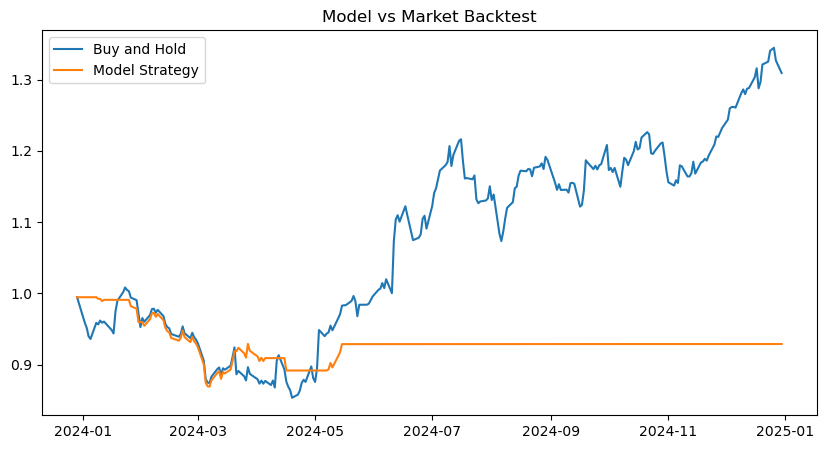

In [24]:
# plot The performance
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(test["Cumulative_Market_Return"], label="Buy and Hold")
plt.plot(test["Cumulative_Model_Return"], label="Model Strategy")
plt.legend()
plt.title("Model vs Market Backtest")
plt.show()

In [26]:
# Evaluate metrics
# Total return
total_return = test["Cumulative_Model_Return"].iloc[-1] - 1

# Annualized Sharpe ratio (risk-adjusted return)
sharpe = test["Strategy_Return"].mean() / test["Strategy_Return"].std() * (252 ** 0.5)

print("Total Return:", round(total_return * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe, 2))

Total Return: -7.11 %
Sharpe Ratio: -0.92


'''
Backtesting limitations

Look ahead bias: Using future info(even accidentally) inflates the performance
Survivorship bias: only using stocks that survived until today ignores delisted companies
No transaction costs: Real trading has fees, slippage, and taxes that reduce profit.

'''

